In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
from tvDatafeed import TvDatafeed, Interval
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import mapie

In [4]:
username = ''
password = ''

tv = TvDatafeed(username, password)

error while signin
you are using nologin method, data you access may be limited


In [5]:
data = tv.get_hist(symbol='ethusdt',exchange='BINANCE',interval=Interval.in_15_minute,n_bars=100000)

In [6]:
data.head()

,symbol,open,high,low,close,volume
datetime,,,,,,
2024-08-01 07:00:00,BINANCE:ethusdt,3232.74,3242.51,3231.01,3236.97,1411.0904
2024-08-01 07:15:00,BINANCE:ethusdt,3236.98,3242.57,3221.01,3221.01,2298.0478
2024-08-01 07:30:00,BINANCE:ethusdt,3221.01,3239.81,3219.44,3229.23,1389.0404
2024-08-01 07:45:00,BINANCE:ethusdt,3229.23,3236.81,3214.21,3235.01,2600.5303
2024-08-01 08:00:00,BINANCE:ethusdt,3235.00,3239.45,3217.54,3224.39,2302.8958


In [7]:
X = data['close'].values
X = X.astype('float32')
# X = X.reshape(-1,1)

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1))

In [9]:
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
train, test = X[0:train_size,:], X[train_size:len(X),:]

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX = trainX.reshape(trainX.shape[0], 60)

In [12]:
mod1 = XGBRegressor(learning_rate=0.1)

In [13]:
trainY.shape

(4656,)

In [14]:
mod1.fit(trainX,trainY)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
prediction = mod1.predict(testX)
prediction = scaler.inverse_transform(prediction.reshape(-1,1))

In [16]:
len(prediction)

464

In [17]:
train = data[:train_size + 60 + 1]
test = data[train_size + 60 + 1::]
test['Prediction'] = prediction

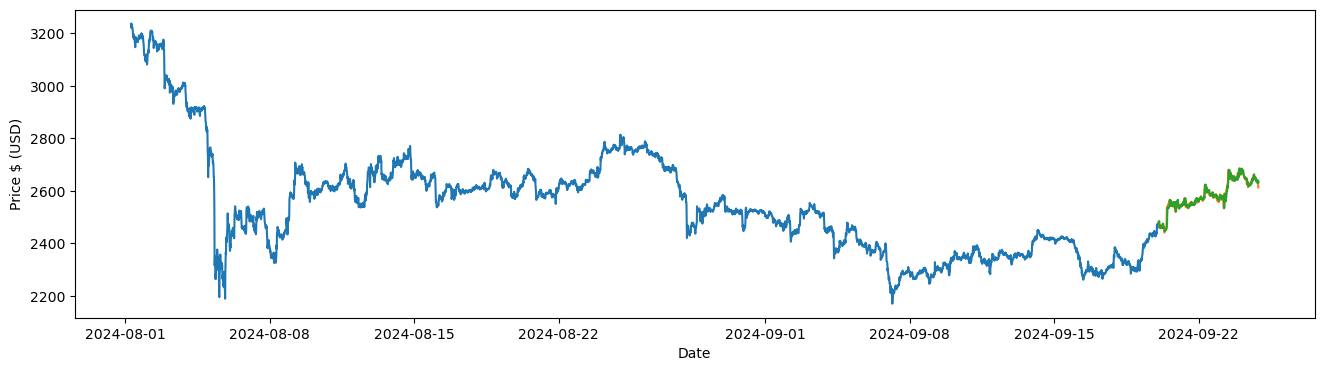

In [18]:
plt.figure(figsize=(16, 4))
plt.xlabel('Date')
plt.ylabel('Price $ (USD)')
plt.plot(train['close'])
plt.plot(test[['close', 'Prediction']])

In [19]:
np.mean(np.abs(test['close'] - test['Prediction']))

7.269223443393042

In [20]:
trade_df = test[['close','Prediction','open']]
trade_df['action'] = np.where(trade_df.open>trade_df.Prediction,'sell','buy')
trade_df['gp'] = np.where(trade_df.action=='buy',(trade_df.close-trade_df.open)/trade_df.open,(trade_df.open-trade_df.close)/trade_df.close)
trade_df = trade_df.iloc[1:]

trade_df

,close,Prediction,open,action,gp
datetime,,,,,
2024-09-20 01:45:00,2475.16,2484.883057,2481.36,buy,-0.002499
2024-09-20 02:00:00,2466.89,2483.271240,2475.17,buy,-0.003345
2024-09-20 02:15:00,2464.55,2473.824951,2466.90,buy,-0.000953
2024-09-20 02:30:00,2467.81,2461.267090,2464.55,sell,-0.001321
2024-09-20 02:45:00,2460.93,2461.267090,2467.81,sell,0.002796
...,...,...,...,...,...
2024-09-24 20:15:00,2632.01,2629.967041,2637.50,sell,0.002086
2024-09-24 20:30:00,2639.26,2634.485596,2632.01,buy,0.002755
2024-09-24 20:45:00,2634.35,2631.221680,2639.26,sell,0.001864


In [21]:
# Using var and cvar as stop loss.
var =[]
for i in range(len(trade_df.gp.values)):
    var.append(np.quantile(trade_df.gp.iloc[:i+1],q=0.05))

cvar = []
for i in range(len(var)):
    cvar.append(np.mean(var[:i]))

In [22]:
trade_df['VaR'] = var
cvar[0] = var[0]
trade_df['CVaR'] = cvar
trade_df['E[R]'] = np.where(trade_df.action=='buy',(trade_df.Prediction - trade_df.open)/trade_df.open,(-trade_df.Prediction + trade_df.open)/trade_df.Prediction)

trade_df['analysis'] = np.where(trade_df.gp > trade_df['E[R]'],'bad RR','Good RR')
trade_df

,close,Prediction,open,action,gp,VaR,CVaR,E[R],analysis
datetime,,,,,,,,,
2024-09-20 01:45:00,2475.16,2484.883057,2481.36,buy,-0.002499,-0.002499,-0.002499,0.001420,Good RR
2024-09-20 02:00:00,2466.89,2483.271240,2475.17,buy,-0.003345,-0.003303,-0.002499,0.003273,Good RR
2024-09-20 02:15:00,2464.55,2473.824951,2466.90,buy,-0.000953,-0.003261,-0.002901,0.002807,Good RR
2024-09-20 02:30:00,2467.81,2461.267090,2464.55,sell,-0.001321,-0.003218,-0.003021,0.001334,Good RR
2024-09-20 02:45:00,2460.93,2461.267090,2467.81,sell,0.002796,-0.003176,-0.003070,0.002658,bad RR
...,...,...,...,...,...,...,...,...,...
2024-09-24 20:15:00,2632.01,2629.967041,2637.50,sell,0.002086,-0.003980,-0.003898,0.002864,Good RR
2024-09-24 20:30:00,2639.26,2634.485596,2632.01,buy,0.002755,-0.003977,-0.003898,0.000941,bad RR
2024-09-24 20:45:00,2634.35,2631.221680,2639.26,sell,0.001864,-0.003974,-0.003898,0.003055,Good RR


In [23]:
gp_var = []
for i in range(len(trade_df)):
    if trade_df.gp[i] > trade_df.VaR[i]:
        gp_var.append(trade_df.gp[i])
    else:
        gp_var.append(trade_df.VaR[i])

In [24]:
gp_cvar = []
for i in range(len(trade_df)):
    if trade_df.gp[i] > trade_df.CVaR[i]:
        gp_cvar.append(trade_df.gp[i])
    else:
        gp_cvar.append(trade_df.CVaR[i])

In [41]:
# capital growth if not using any stop-loss
capital = 10000
for i in trade_df.gp.values:
    capital*=(1+i)
print(capital)

9377.973483672245


In [44]:
# capital growth if using VaR as stop-loss
capital = 10000
for i in gp_var:
    capital*=(1+i)
print(capital)

10014.458589988692


In [45]:
# capital growth if using CVaR as stop-loss
capital = 10000
for i in gp_cvar:
    capital*=(1+i)
print(capital)

10107.563541441676


# Trade Summary

In [46]:
trade_df.tail()

,close,Prediction,open,action,gp,VaR,CVaR,E[R],analysis
datetime,,,,,,,,,
2024-09-24 20:15:00,2632.01,2629.967041,2637.50,sell,0.002086,-0.003980,-0.003898,0.002864,Good RR
2024-09-24 20:30:00,2639.26,2634.485596,2632.01,buy,0.002755,-0.003977,-0.003898,0.000941,bad RR
2024-09-24 20:45:00,2634.35,2631.221680,2639.26,sell,0.001864,-0.003974,-0.003898,0.003055,Good RR
2024-09-24 21:00:00,2615.58,2638.485352,2634.35,buy,-0.007125,-0.004028,-0.003898,0.001570,Good RR
2024-09-24 21:15:00,2613.02,2633.392090,2615.58,buy,-0.000979,-0.004025,-0.003898,0.006810,Good RR


In [74]:
def format_datetime(dt):
    return pd.Timestamp(dt).strftime("%Y-%m-%d %H:%M")

In [82]:
print(f'at {format_datetime(trade_df.tail(1).index.values[0])}, the action is {trade_df.tail(1).action.values[0]}') 

if trade_df.tail(1).action.values=='buy':
    print(f'cut loss at {trade_df.tail(1).open.values[0] * (1+trade_df.tail(1).CVaR.values[0])}, price go up to approximately {trade_df.Prediction.tail(1).values[0]}')
else:
    print(f'cut loss at {trade_df.tail(1).open.values[0] * (1-trade_df.tail(1).CVaR.values[0])}, price go down to approximately {trade_df.Prediction.tail(1).values[0]}')

at 2024-09-24 21:15, the action is buy
cut loss at 2605.383368921692, price go up to approximately 2633.39208984375
